In [1]:
import numpy as np
import matplotlib.cm as cm
import pandas as pd
from possibilearn.kernel import GaussianKernel
import math
import itertools as it
import gurobipy as gpy

source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

iris_df = pd.read_csv(
    filepath_or_buffer=source,
    header=None,
    sep=',')

iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df.dropna(how="all", inplace=True) # drops the empty line at file-end

iris_values = iris_df.iloc[:,:4].values #array dei soli valori
iris_labels = iris_df.iloc[:,4].values #array delle etichette

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

iris_values_std = StandardScaler().fit_transform(iris_values)

pca_2d = PCA(n_components=2)
iris_values_2d = pca_2d.fit_transform(iris_values_std)

pca_3d = PCA(n_components=3)
iris_values_3d = pca_3d.fit_transform(iris_values_std)

pca_4d = PCA(n_components=4)
iris_values_4d = pca_4d.fit_transform(iris_values_std)

print iris_values_2d

[[-2.26454173e+00  5.05703903e-01]
 [-2.08642550e+00 -6.55404729e-01]
 [-2.36795045e+00 -3.18477311e-01]
 [-2.30419716e+00 -5.75367713e-01]
 [-2.38877749e+00  6.74767397e-01]
 [-2.07053681e+00  1.51854856e+00]
 [-2.44571134e+00  7.45626750e-02]
 [-2.23384186e+00  2.47613932e-01]
 [-2.34195768e+00 -1.09514636e+00]
 [-2.18867576e+00 -4.48629048e-01]
 [-2.16348656e+00  1.07059558e+00]
 [-2.32737775e+00  1.58587455e-01]
 [-2.22408272e+00 -7.09118158e-01]
 [-2.63971626e+00 -9.38281982e-01]
 [-2.19229151e+00  1.88997851e+00]
 [-2.25146521e+00  2.72237108e+00]
 [-2.20275048e+00  1.51375028e+00]
 [-2.19017916e+00  5.14304308e-01]
 [-1.89407429e+00  1.43111071e+00]
 [-2.33994907e+00  1.15803343e+00]
 [-1.91455639e+00  4.30465163e-01]
 [-2.20464540e+00  9.52457317e-01]
 [-2.77416979e+00  4.89517027e-01]
 [-1.82041156e+00  1.06750793e-01]
 [-2.22821750e+00  1.62186163e-01]
 [-1.95702401e+00 -6.07892567e-01]
 [-2.05206331e+00  2.66014312e-01]
 [-2.16819365e+00  5.52016495e-01]
 [-2.14030596e+00  3

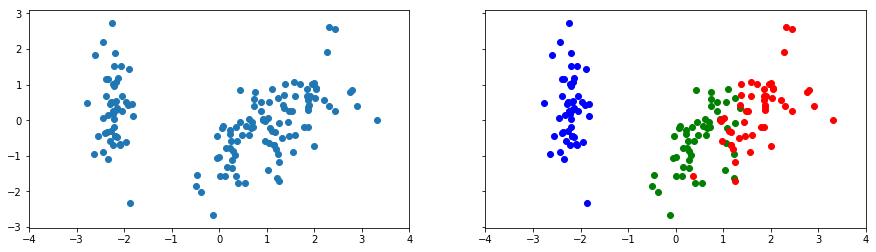

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2,
sharey=True, figsize=(15, 4))
fig.subplots_adjust(wspace=0.2)

axs[0].scatter(iris_values_2d[:,0],iris_values_2d[:,1]) #grafico di tutti i punti, senza appartenenza
axs[0].set_xlim(-4,4)

for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), #grafico con appartenenza
                        ('blue', 'green', 'red')):
        axs[1].scatter(iris_values_2d[iris_labels==lab, 0],
                    iris_values_2d[iris_labels==lab, 1],
                    label=lab,
                    c=col)
axs[1].set_xlim(-4,4)        

plt.show()

In [4]:
def solve_wolf(x,k,p):

    n=len(x)
    c=1/(n*p) # SVC(18)
    print "c is %f" %c

    model = gpy.Model('Wolf')

    for i in range(n):
        model.addVar(name="beta_%d" %i, lb=-1, vtype=gpy.GRB.CONTINUOUS)

    model.update()
    b = model.getVars()

    # obj == - SVC(11) 
    obj = gpy.QuadExpr()
    for i, j in it.product(range(n), range(n)):
        obj.add( b[i] * b[j], k.compute(x[i], x[j]))
    
    for i in range(n):
        obj.add( -1 * b[i] * k.compute(x[i], x[i]))
    
    model.setObjective(obj, gpy.GRB.MINIMIZE) #minimizzo -SVC(11) anzichè massimizzare SVC(11)
    
    constEqual = gpy.LinExpr()
    constEqual.add(sum(b), 1.0) # SVC(3)

    model.addConstr(constEqual, gpy.GRB.EQUAL, 1)
    
    #SVC(9)
    for i in range(n):
        model.addConstr(b[i], gpy.GRB.GREATER_EQUAL, 0)
        model.addConstr(b[i], gpy.GRB.LESS_EQUAL, c)

    model.optimize()

    betas = [v.x for v in model.getVars()]
    return betas

q=6
k=GaussianKernel(q)
p=0.6
c=1/(len(iris_values_2d) * p)
beta_opt_2d = solve_wolf(iris_values_2d,k,p)
#beta_opt_3d = solve_wolf(iris_values_3d,7,0.7)
#beta_opt_4d = solve_wolf(iris_values_4d,9,0.75)

c is 0.011111
Optimize a model with 301 rows, 150 columns and 450 nonzeros
Model has 11325 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 300 rows and 0 columns
Presolve time: 0.02s
Presolved: 1 rows, 150 columns, 150 nonzeros
Presolved model has 11325 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 37
 AA' NZ     : 7.030e+02
 Factor NZ  : 7.410e+02
 Factor Ops : 1.902e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.50000654e+05 -1.66784611e+03  1.50e+05 4.68e-01  1.00e+06     0s
   1  -1.52225681e+02 -1.66658329e+03  1.52e+02 4.74e-04  1.02e+03     0s
   2  -9.69991341e-02 -1.64775283e+03  1.52e-04 4.74e-10  5.49e+00     0s


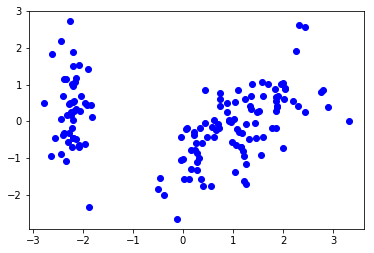

SV are 150


In [5]:
count=0
for i in range(len(iris_values_2d)):
    if 0 < beta_opt_2d[i] < c:
        plt.plot(iris_values_2d[i][0],iris_values_2d[i][1],'bo')
        count=count + 1
    else:
        plt.plot(iris_values_2d[i][0],iris_values_2d[i][1],'go')

plt.show()
print "SV are %d" %count

L'unico modo che ho per capire se un x[i] sia un Support Vector è che la rispettiva beta[i] sia compresa tra 0 e C esclusi?
solve_wolf però non assegna a nessuna beta[i] nè il valore 0 nè il valore C, e per il vincolo SVC(9) tutti i punti risulterebbero essere Support Vector.
È ragionevole arrotondare (come qui sotto) il valore delle beta[i]? Così facendo ottengo nsv Support Vector

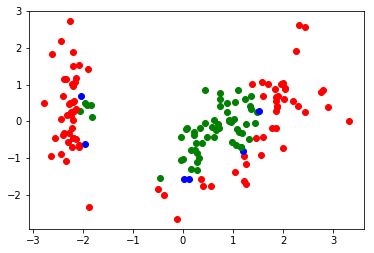

SV (BLU) are 6
BSV (RED) are 86


In [6]:
nbsv=0
nsv=0
nv=0
bsv_i=[]
sv_i=[]
v_i=[]

tr=10 #tronco dopo tr cifre decimali

for i in range(len(iris_values_2d)):
    if round(beta_opt_2d[i],tr) == round(c,tr):
        plt.plot(iris_values_2d[i][0],iris_values_2d[i][1],'ro')
        nbsv=nbsv+1
        bsv_i.append(i)
    elif 0 < round(beta_opt_2d[i],tr) < round(c,tr):
        plt.plot(iris_values_2d[i][0],iris_values_2d[i][1],'bo')
        nsv=nsv + 1
        sv_i.append(i)
    else:
        plt.plot(iris_values_2d[i][0],iris_values_2d[i][1],'go')
        nv=nv+1
        v_i.append(i)


plt.show()
print "SV (BLU) are %d" %nsv
print "BSV (RED) are %d" %nbsv

In [7]:
sv = iris_values_2d[sv_i]
#print sv

In [8]:
def distance_from_center(x,p,beta,k):
    
    d1 = k.compute(p,p)
    d2 = np.array([k.compute(x_i, p) for x_i in x]).dot(beta)
    d3 = np.array(np.array([[k.compute(x1, x2) for x1 in x] for x2 in x]))
    d3 = np.array(beta).dot(d3.dot(beta))
    d = d1 - 2 * d2 + d3
    return d

radius = np.mean(np.array([distance_from_center(iris_values_2d,p_i,beta_opt_2d,k) for p_i in sv]))
print "raggio della sfera: %f" % radius

raggio della sfera: 0.085266


In [9]:
#devo fare la clusterizzazione dei soli punti appartenenti alla sfera (SV + V), BSV vengono assegnati ai cluster
#successivamente
cl_i = sv_i + v_i
cl_i.sort()
cl_i
cl = iris_values_2d[cl_i]
cl_i

[20,
 23,
 25,
 26,
 31,
 36,
 43,
 50,
 51,
 52,
 54,
 55,
 56,
 58,
 59,
 61,
 63,
 64,
 65,
 66,
 67,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 98,
 99,
 101,
 103,
 110,
 116,
 121,
 123,
 126,
 127,
 133,
 134,
 137,
 138,
 142,
 147,
 149]

In [10]:
def adjacency_matrix(x,beta,k,cl,cl_i,radius):
    
    couples = []
    couples_i = []
    i=0
    while i < len(cl):
        j=i+1
        while j < len(cl):
            couples.append([cl[i],cl[j]])
            couples_i.append([cl_i[i],cl_i[j]])
            j=j+1
        i=i+1
        
    d3 = np.array(np.array([[k.compute(x1, x2) for x1 in x] for x2 in x]))
    d3 = np.array(beta).dot(d3.dot(beta))
        
    def distance_from_center_2(x,p,fixed):
        d1 = k.compute(p,p)
        d2 = np.array([k.compute(x_i, p) for x_i in x]).dot(beta)
        d = d1 - 2 * d2 + fixed
        return d

    def random_point_on_segment(p1,p2):
        import random
        x1,y1 = p1[0],p1[1]
        x2,y2 = p2[0],p2[1]
        if (x1-x2 != 0):
            x = random.uniform(x1,x2)
            return [x ,((x-x1)*(y2-y1)/(x2-x1) + y1)]
        else:
            return[x1,random.uniform(y1,y2)]

    def same_cluster(p1,p2,np):
        i=0
        while i < np:
            if distance_from_center_2(x,random_point_on_segment(p1,p2),d3) > radius:
                return 0
            i=i+1
        return 1
            
    D = {}
    for i in range(len(couples)):
        D[ (couples_i[i][0],couples_i[i][1]) ] = same_cluster(couples[i][0],couples[i][1],20)
        
    return D
        


D = adjacency_matrix(iris_values_2d,beta_opt_2d,k,cl,cl_i,radius)

In [11]:
import networkx as nx
G=nx.Graph()
G.add_nodes_from(cl_i)

for x in D:
    if D[x]==1:
        G.add_edge(x[0],x[1])

list(nx.connected_components(G))

[{20,
  23,
  25,
  26,
  31,
  36,
  43,
  50,
  51,
  52,
  54,
  55,
  56,
  58,
  59,
  61,
  63,
  64,
  65,
  66,
  67,
  69,
  70,
  71,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  88,
  89,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  98,
  99,
  101,
  103,
  110,
  116,
  121,
  123,
  126,
  127,
  133,
  134,
  137,
  138,
  142,
  147,
  149}]